Parsed ./N1024_h12_tp2.log
Parsed ./N1024_h12_tp4.log
Parsed ./N1024_h12_tp8.log
Parsed ./N1024_h12_tp16.log
Parsed ./N1024_h16_tp2.log
Parsed ./N1024_h16_tp4.log
Parsed ./N1024_h16_tp8.log
Parsed ./N1024_h16_tp16.log
Parsed ./N1024_h20_tp2.log
Parsed ./N1024_h20_tp4.log
Parsed ./N1024_h20_tp8.log
Parsed ./N1024_h20_tp16.log
Parsed ./N2048_h12_tp2.log
Parsed ./N2048_h12_tp4.log
Parsed ./N2048_h12_tp8.log
Parsed ./N2048_h12_tp16.log
Parsed ./N2048_h16_tp2.log
Parsed ./N2048_h16_tp4.log
Parsed ./N2048_h16_tp8.log
Parsed ./N2048_h16_tp16.log
Parsed ./N2048_h20_tp2.log
Parsed ./N2048_h20_tp4.log
Parsed ./N2048_h20_tp8.log
Parsed ./N2048_h20_tp16.log
Parsed ./N4096_h12_tp2.log
Parsed ./N4096_h12_tp4.log
Parsed ./N4096_h12_tp8.log
Parsed ./N4096_h12_tp16.log
Parsed ./N4096_h16_tp2.log
Parsed ./N4096_h16_tp4.log
Parsed ./N4096_h16_tp8.log
Parsed ./N4096_h16_tp16.log
Parsed ./N4096_h20_tp2.log
Parsed ./N4096_h20_tp4.log
Parsed ./N4096_h20_tp8.log
Parsed ./N4096_h20_tp16.log
Parsed ./N8192_h12_

,file,N,h,tp,final_train_loss,final_valid_loss,final_train_cos_loss,final_vocab_cro_loss,final_valid_cos_loss
0,N1024_h12_tp2.log,1024,12,2,2.2858,3.1899,0.020305,2.299904,0.056162
1,N1024_h12_tp4.log,1024,12,4,2.2417,3.1363,0.015689,2.304061,0.081569
2,N1024_h12_tp8.log,1024,12,8,1.2707,2.2676,0.007697,1.245821,0.015347
3,N1024_h12_tp16.log,1024,12,16,0.9916,2.0482,0.005274,0.993987,0.008472
4,N1024_h16_tp2.log,1024,16,2,2.1456,2.8130,0.017932,2.140228,0.044285
...,...,...,...,...,...,...,...,...,...
67,N32768_h16_tp16.log,32768,16,16,1.4961,2.1190,0.007473,1.495780,0.008206
68,N32768_h20_tp2.log,32768,20,2,2.7393,3.2681,0.031580,2.739497,0.037721
69,N32768_h20_tp4.log,32768,20,4,2.4547,3.0237,0.022835,2.452183,0.060058
70,N32768_h20_tp8.log,32768,20,8,1.6910,2.3291,0.011041,1.692575,0.013526


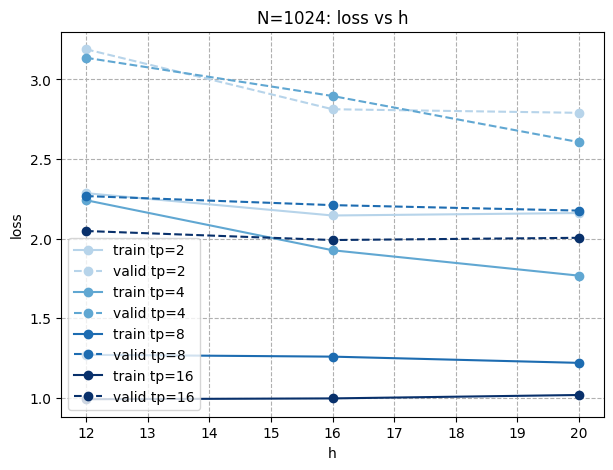

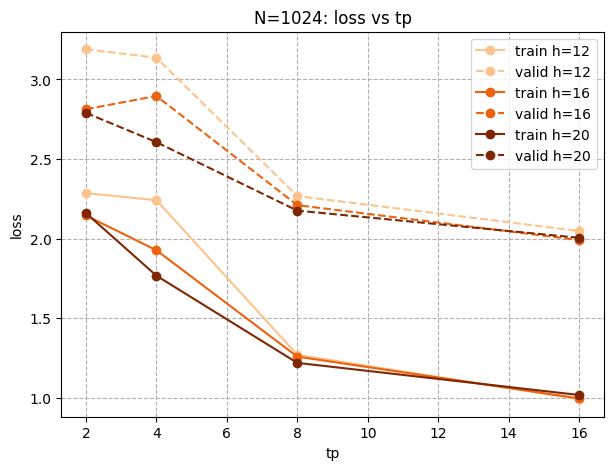

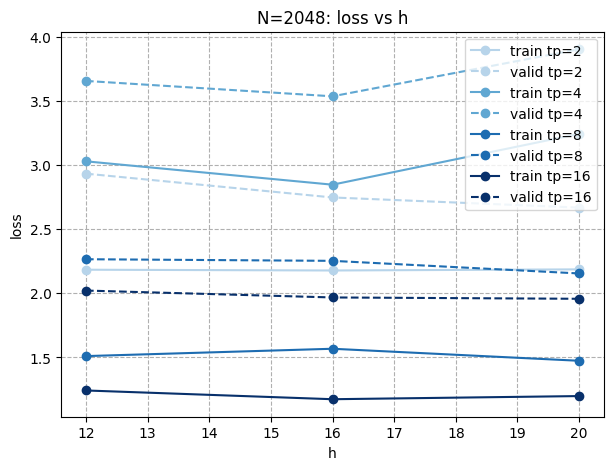

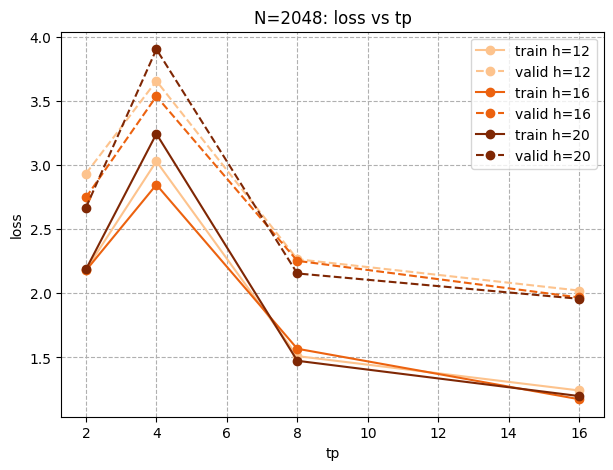

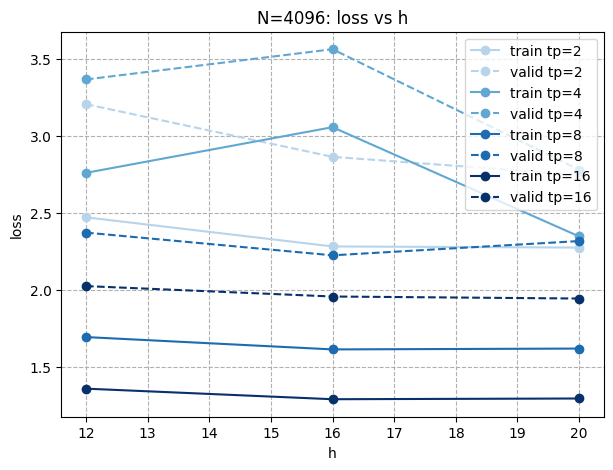

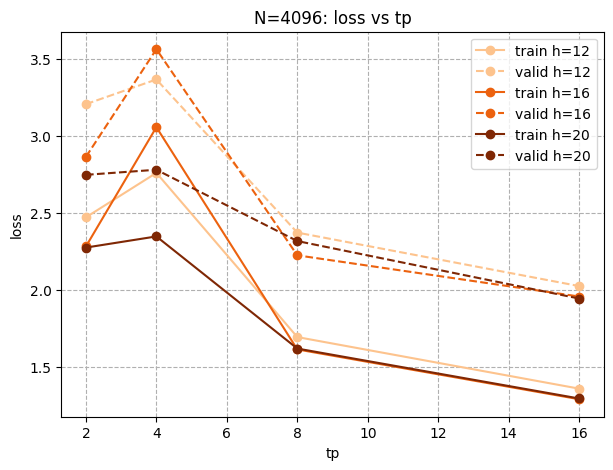

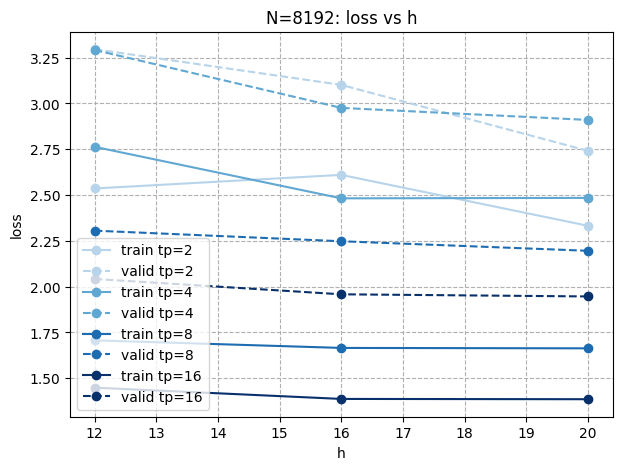

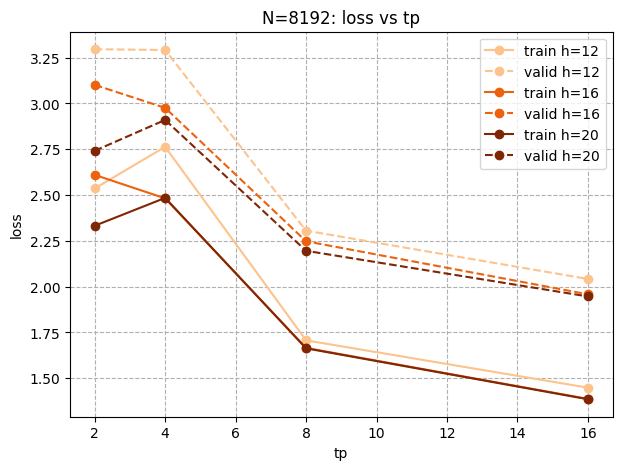

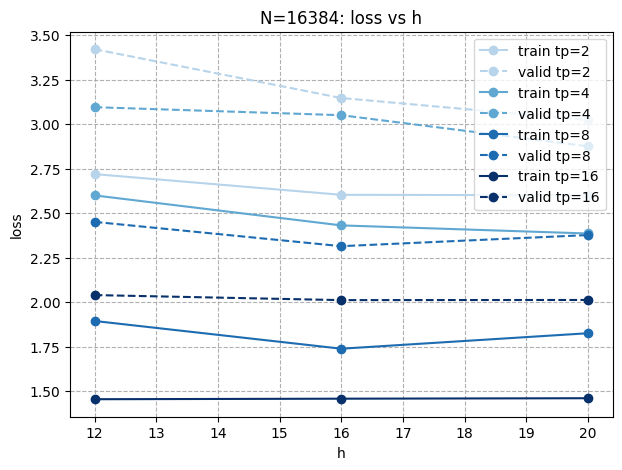

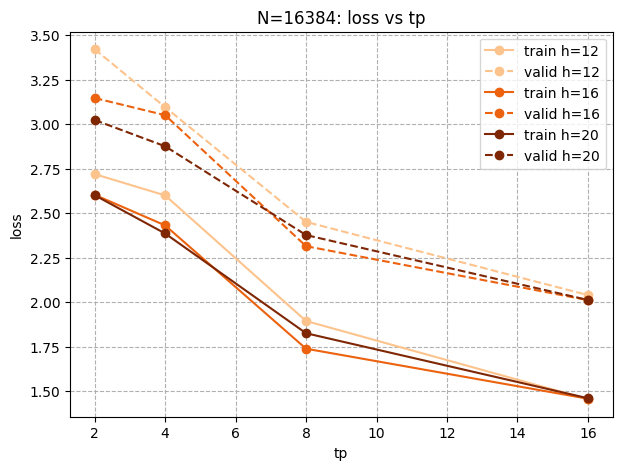

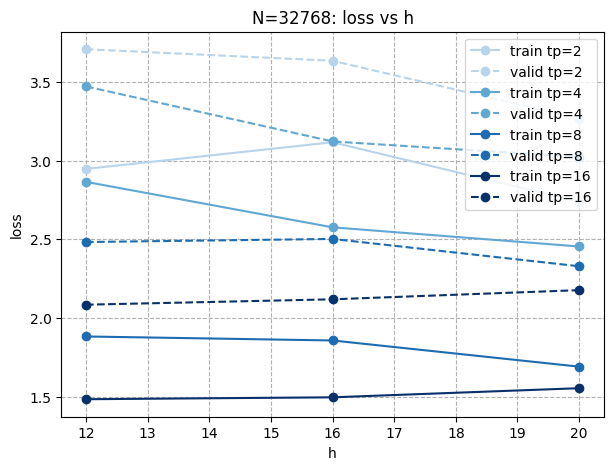

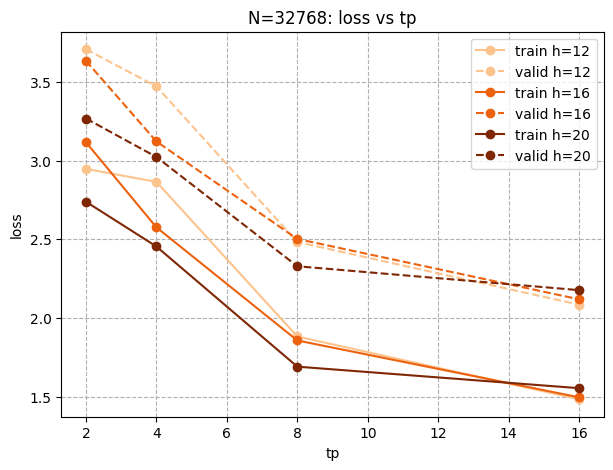

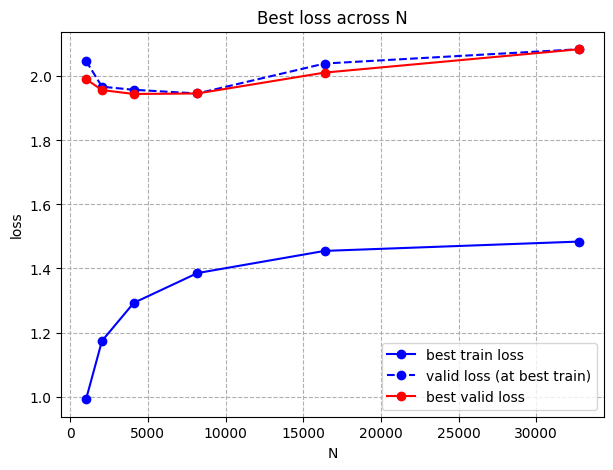

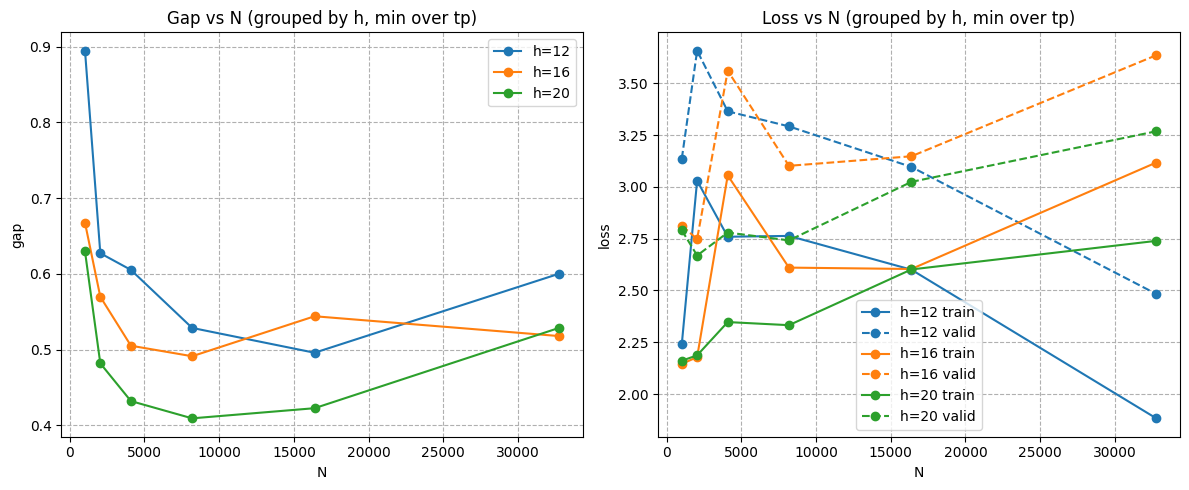

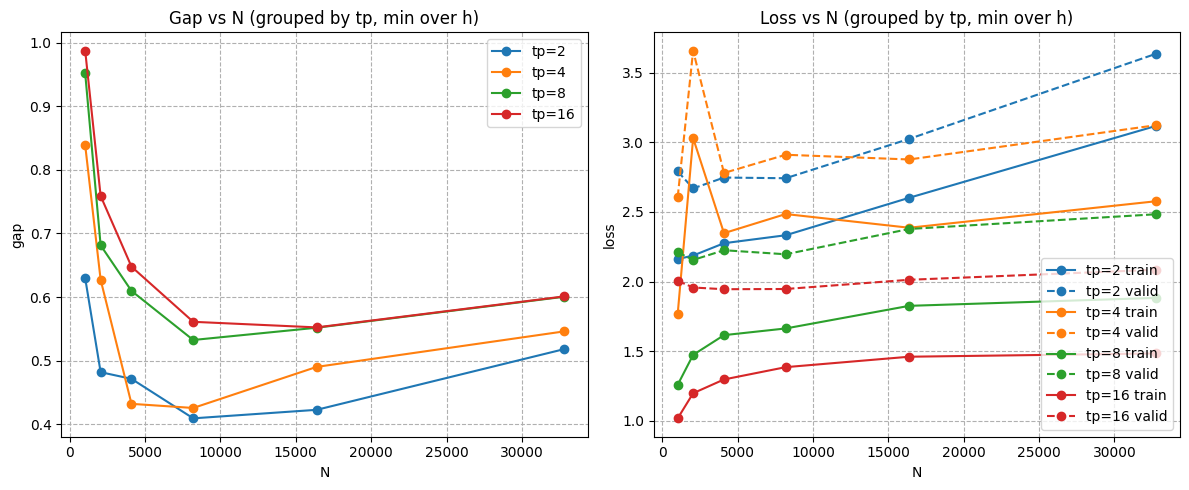

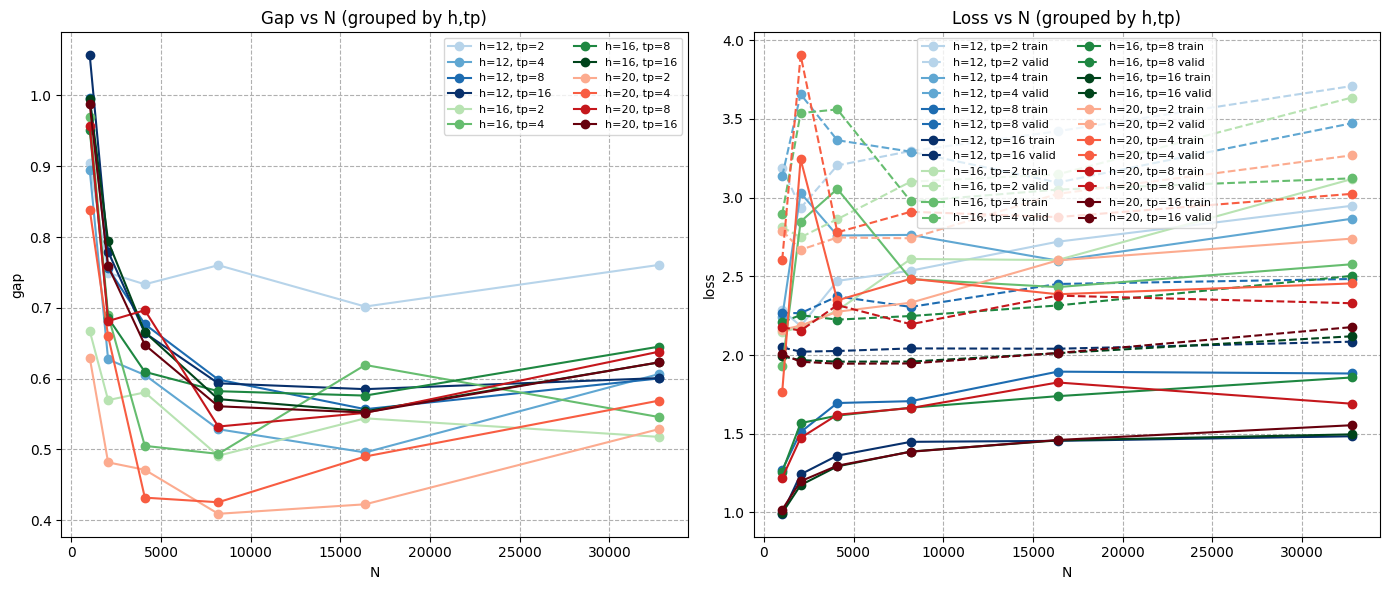

In [ ]:
# =========================
# Step 0: 依赖
# =========================
import os
import re
from typing import Dict, List, Any
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# =========================
# Step 1: 文件名生成层
# =========================
def make_log_filename(N: int, h: int, tp: int, prefix: str = "N") -> str:
    return f"{prefix}{N}_h{h}_tp{tp}.log"

def make_log_filenames(N_list, h_list, tp_list, prefix="N") -> List[str]:
    return [make_log_filename(N, h, tp, prefix) for N in N_list for h in h_list for tp in tp_list]

def list_existing_logs(log_dir: str, candidates: List[str]) -> List[str]:
    return [os.path.join(log_dir, f) for f in candidates if os.path.exists(os.path.join(log_dir, f))]

# =========================
# Step 2: 解析引擎层（单文件）
# =========================
FNAME_RE = re.compile(r"^N(?P<N>\d+)_h(?P<h>\d+)_tp(?P<tp>\d+)\.log$")

FLOAT = r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?"
TRAIN_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+(.*)$")
TRAIN_KV_RE      = re.compile(rf"(\w+_loss)\s*:\s*({FLOAT})")
TRAIN_LINE_RE    = re.compile(r"^train loss:\s*(" + FLOAT + r")\s*,\s*accuracy:\s*(" + FLOAT + r")")
VALID_SUMMARY_RE = re.compile(r"^epoch\s+(\d+)\s+summary:\s+.*(valid_cos_loss)\s*:\s*(" + FLOAT + r")")
VALID_LINE_RE    = re.compile(r"^valid loss:\s*(" + FLOAT + r")\s*,\s*accuracy:\s*(" + FLOAT + r")")

def parse_filename_meta(filename: str) -> Dict[str, Any]:
    m = FNAME_RE.match(filename)
    if not m:
        return {"file": filename, "N": None, "h": None, "tp": None}
    return {
        "file": filename,
        "N": int(m.group("N")),
        "h": int(m.group("h")),
        "tp": int(m.group("tp"))
    }

def parse_log_file(filepath: str) -> Dict[str, Any]:
    meta = parse_filename_meta(os.path.basename(filepath))
    series: Dict[str, List[float]] = {
        "train_cos_loss": [], "vocab_cro_loss": [],
        "train_loss": [], "train_acc": [],
        "valid_cos_loss": [], "valid_loss": [], "valid_acc": []
    }
    epochs_train: List[int] = []
    epochs_valid: List[int] = []
    last_epoch_seen: int | None = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            mt = TRAIN_SUMMARY_RE.match(line)
            if mt:
                ep = int(mt.group(1))
                last_epoch_seen = ep
                kv_part = mt.group(2)
                for k, v in TRAIN_KV_RE.findall(kv_part):
                    if k in series:
                        series[k].append(float(v))
                epochs_train.append(ep)
                continue

            mt = TRAIN_LINE_RE.match(line)
            if mt:
                t_loss, t_acc = float(mt.group(1)), float(mt.group(2))
                series["train_loss"].append(t_loss)
                series["train_acc"].append(t_acc)
                continue

            mv = VALID_SUMMARY_RE.match(line)
            if mv:
                ep_v = int(mv.group(1))
                last_epoch_seen = ep_v
                val_cos = float(mv.group(3))
                series["valid_cos_loss"].append(val_cos)
                epochs_valid.append(ep_v)
                continue

            mv = VALID_LINE_RE.match(line)
            if mv:
                v_loss, v_acc = float(mv.group(1)), float(mv.group(2))
                series["valid_loss"].append(v_loss)
                series["valid_acc"].append(v_acc)
                if last_epoch_seen is not None and (not epochs_valid or epochs_valid[-1] != last_epoch_seen):
                    epochs_valid.append(last_epoch_seen)
                continue

    return {"meta": meta, "series": series, "epochs_train": epochs_train, "epochs_valid": epochs_valid}

# =========================
# Step 3: 批量收集层
# =========================
def parse_multiple_logs(filepaths: List[str]) -> List[Dict[str, Any]]:
    runs = []
    for p in filepaths:
        try:
            runs.append(parse_log_file(p))
            print(f"Parsed {p}")
        except Exception as e:
            runs.append({"meta": {"file": os.path.basename(p), "N": None, "h": None, "tp": None},
                         "series": {}, "error": str(e)})
    return runs

# =========================
# Step 4: 聚合与特征派生层
# =========================
def build_final_metrics_table(runs: List[Dict[str, Any]]) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for r in runs:
        meta = r.get("meta", {})
        ser  = r.get("series", {})

        def last_or_nan(lst):
            return lst[-1] if lst else float("nan")

        rows.append({
            "file": meta.get("file"),
            "N": meta.get("N"),
            "h": meta.get("h"),
            "tp": meta.get("tp"),
            "final_train_loss": last_or_nan(ser.get("train_loss", [])),
            "final_valid_loss": last_or_nan(ser.get("valid_loss", [])),
            "final_train_cos_loss": last_or_nan(ser.get("train_cos_loss", [])),
            "final_vocab_cro_loss": last_or_nan(ser.get("vocab_cro_loss", [])),
            "final_valid_cos_loss": last_or_nan(ser.get("valid_cos_loss", [])),
        })
    return pd.DataFrame(rows)

# =========================
# Step 5: 可视化层
# =========================
def plot_loss_by_h_tp(df: pd.DataFrame, N: int):
    dfN = df[df["N"] == N]
    if dfN.empty: 
        print(f"No data for N={N}")
        return

    tp_sorted = sorted(dfN["tp"].unique())
    h_sorted  = sorted(dfN["h"].unique())
    colors_tp = plt.cm.Blues(np.linspace(0.3, 1, len(tp_sorted)))
    color_map_tp = {tp: colors_tp[i] for i, tp in enumerate(tp_sorted)}

    colors_h  = plt.cm.Oranges(np.linspace(0.3, 1, len(h_sorted)))
    color_map_h = {h: colors_h[i] for i, h in enumerate(h_sorted)}
    
    
    # fig1: 横轴 h, grouped by tp
    fig, ax = plt.subplots(figsize=(7,5))
    for tp, grp in dfN.groupby("tp"):
        g = grp.sort_values("h")
        ax.plot(g["h"], g["final_train_loss"], color=color_map_tp[tp], marker="o", label=f"train tp={tp}", linestyle="-")
        ax.plot(g["h"], g["final_valid_loss"], color=color_map_tp[tp], marker="o", label=f"valid tp={tp}", linestyle="--")
    ax.set_xlabel("h"); ax.set_ylabel("loss"); ax.set_title(f"N={N}: loss vs h")
    ax.legend(); ax.grid(True, ls="--"); plt.show()

    # fig2: 横轴 tp, grouped by h
    fig, ax = plt.subplots(figsize=(7,5))
    for h, grp in dfN.groupby("h"):
        g = grp.sort_values("tp")
        ax.plot(g["tp"], g["final_train_loss"], color=color_map_h[h], marker="o", label=f"train h={h}", linestyle="-")
        ax.plot(g["tp"], g["final_valid_loss"], color=color_map_h[h], marker="o", label=f"valid h={h}", linestyle="--")
    ax.set_xlabel("tp"); ax.set_ylabel("loss"); ax.set_title(f"N={N}: loss vs tp")
    ax.legend(); ax.grid(True, ls="--"); plt.show()

def plot_best_loss_across_N(df: pd.DataFrame):
    records = []
    for N, grp in df.groupby("N"):
        idx_train = grp["final_train_loss"].idxmin()
        best_train = grp.loc[idx_train,"final_train_loss"]
        best_valid_from_train = grp.loc[idx_train,"final_valid_loss"]

        idx_valid = grp["final_valid_loss"].idxmin()
        best_valid = grp.loc[idx_valid,"final_valid_loss"]

        records.append({"N":N, "best_train":best_train,
                        "best_valid_from_train":best_valid_from_train,
                        "best_valid":best_valid})

    dfb = pd.DataFrame(records).sort_values("N")

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(dfb["N"], dfb["best_train"], "b-", marker="o", label="best train loss")
    ax.plot(dfb["N"], dfb["best_valid_from_train"], "b--", marker="o", label="valid loss (at best train)")
    ax.plot(dfb["N"], dfb["best_valid"], "r-", marker="o", label="best valid loss")
    ax.set_xlabel("N"); ax.set_ylabel("loss"); ax.set_title("Best loss across N")
    ax.legend(); ax.grid(True, ls="--"); plt.show()

import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_generalization_gap(df: pd.DataFrame):
    """
    绘制 generalization gap:
    - 左图: gap vs N
    - 右图: train_loss vs N (实线), valid_loss vs N (虚线)，颜色与左图一致
    """
    df = df.copy()
    df["gap"] = df["final_valid_loss"] - df["final_train_loss"]

    # --- 图1: group by h ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    for h, grp in df.groupby("h"):
        records_gap, records_train, records_valid = [], [], []
        for N, sub in grp.groupby("N"):
            min_gap = sub["gap"].min()
            min_train = sub.loc[sub["gap"].idxmin(), "final_train_loss"]
            min_valid = sub.loc[sub["gap"].idxmin(), "final_valid_loss"]
            records_gap.append({"N": N, "gap": min_gap})
            records_train.append({"N": N, "train": min_train})
            records_valid.append({"N": N, "valid": min_valid})

        g_gap = pd.DataFrame(records_gap).sort_values("N")
        g_train = pd.DataFrame(records_train).sort_values("N")
        g_valid = pd.DataFrame(records_valid).sort_values("N")

        # 颜色一致
        color = next(ax1._get_lines.prop_cycler)["color"]

        ax1.plot(g_gap["N"], g_gap["gap"], marker="o", color=color, label=f"h={h}")
        ax2.plot(g_train["N"], g_train["train"], marker="o", color=color, ls="-", label=f"h={h} train")
        ax2.plot(g_valid["N"], g_valid["valid"], marker="o", color=color, ls="--", label=f"h={h} valid")

    ax1.set_title("Gap vs N (grouped by h, min over tp)")
    ax1.set_xlabel("N"); ax1.set_ylabel("gap"); ax1.grid(True, ls="--"); ax1.legend()

    ax2.set_title("Loss vs N (grouped by h, min over tp)")
    ax2.set_xlabel("N"); ax2.set_ylabel("loss"); ax2.grid(True, ls="--"); ax2.legend()

    plt.tight_layout()
    plt.show()

    # --- 图2: group by tp ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    for tp, grp in df.groupby("tp"):
        records_gap, records_train, records_valid = [], [], []
        for N, sub in grp.groupby("N"):
            min_gap = sub["gap"].min()
            min_train = sub.loc[sub["gap"].idxmin(), "final_train_loss"]
            min_valid = sub.loc[sub["gap"].idxmin(), "final_valid_loss"]
            records_gap.append({"N": N, "gap": min_gap})
            records_train.append({"N": N, "train": min_train})
            records_valid.append({"N": N, "valid": min_valid})

        g_gap = pd.DataFrame(records_gap).sort_values("N")
        g_train = pd.DataFrame(records_train).sort_values("N")
        g_valid = pd.DataFrame(records_valid).sort_values("N")

        # 颜色一致
        color = next(ax1._get_lines.prop_cycler)["color"]

        ax1.plot(g_gap["N"], g_gap["gap"], marker="o", color=color, label=f"tp={tp}")
        ax2.plot(g_train["N"], g_train["train"], marker="o", color=color, ls="-", label=f"tp={tp} train")
        ax2.plot(g_valid["N"], g_valid["valid"], marker="o", color=color, ls="--", label=f"tp={tp} valid")

    ax1.set_title("Gap vs N (grouped by tp, min over h)")
    ax1.set_xlabel("N"); ax1.set_ylabel("gap"); ax1.grid(True, ls="--"); ax1.legend()

    ax2.set_title("Loss vs N (grouped by tp, min over h)")
    ax2.set_xlabel("N"); ax2.set_ylabel("loss"); ax2.grid(True, ls="--"); ax2.legend()

    plt.tight_layout()
    plt.show()


import itertools

def plot_generalization_gap(df: pd.DataFrame):
    """
    绘制 generalization gap:
    - 左图: gap vs N
    - 右图: train_loss vs N (实线), valid_loss vs N (虚线)，颜色与左图一致
    """
    df = df.copy()
    df["gap"] = df["final_valid_loss"] - df["final_train_loss"]

    # --- 图1: group by h ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for h, grp in df.groupby("h"):
        records_gap, records_train, records_valid = [], [], []
        for N, sub in grp.groupby("N"):
            min_idx = sub["gap"].idxmin()
            records_gap.append({"N": N, "gap": sub.loc[min_idx, "gap"]})
            records_train.append({"N": N, "train": sub.loc[min_idx, "final_train_loss"]})
            records_valid.append({"N": N, "valid": sub.loc[min_idx, "final_valid_loss"]})

        g_gap = pd.DataFrame(records_gap).sort_values("N")
        g_train = pd.DataFrame(records_train).sort_values("N")
        g_valid = pd.DataFrame(records_valid).sort_values("N")

        color = next(color_cycle)
        ax1.plot(g_gap["N"], g_gap["gap"], marker="o", color=color, label=f"h={h}")
        ax2.plot(g_train["N"], g_train["train"], marker="o", color=color, ls="-", label=f"h={h} train")
        ax2.plot(g_valid["N"], g_valid["valid"], marker="o", color=color, ls="--", label=f"h={h} valid")

    ax1.set_title("Gap vs N (grouped by h, min over tp)")
    ax1.set_xlabel("N"); ax1.set_ylabel("gap"); ax1.grid(True, ls="--"); ax1.legend()
    ax2.set_title("Loss vs N (grouped by h, min over tp)")
    ax2.set_xlabel("N"); ax2.set_ylabel("loss"); ax2.grid(True, ls="--"); ax2.legend()
    plt.tight_layout(); plt.show()

    # --- 图2: group by tp ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for tp, grp in df.groupby("tp"):
        records_gap, records_train, records_valid = [], [], []
        for N, sub in grp.groupby("N"):
            min_idx = sub["gap"].idxmin()
            records_gap.append({"N": N, "gap": sub.loc[min_idx, "gap"]})
            records_train.append({"N": N, "train": sub.loc[min_idx, "final_train_loss"]})
            records_valid.append({"N": N, "valid": sub.loc[min_idx, "final_valid_loss"]})

        g_gap = pd.DataFrame(records_gap).sort_values("N")
        g_train = pd.DataFrame(records_train).sort_values("N")
        g_valid = pd.DataFrame(records_valid).sort_values("N")

        color = next(color_cycle)
        ax1.plot(g_gap["N"], g_gap["gap"], marker="o", color=color, label=f"tp={tp}")
        ax2.plot(g_train["N"], g_train["train"], marker="o", color=color, ls="-", label=f"tp={tp} train")
        ax2.plot(g_valid["N"], g_valid["valid"], marker="o", color=color, ls="--", label=f"tp={tp} valid")

    ax1.set_title("Gap vs N (grouped by tp, min over h)")
    ax1.set_xlabel("N"); ax1.set_ylabel("gap"); ax1.grid(True, ls="--"); ax1.legend()
    ax2.set_title("Loss vs N (grouped by tp, min over h)")
    ax2.set_xlabel("N"); ax2.set_ylabel("loss"); ax2.grid(True, ls="--"); ax2.legend()
    plt.tight_layout(); plt.show()

# =========================
# Step 6: 示例（按需启用）
# =========================
log_dir = "."
N_list  = [1024, 2048, 4096, 8192, 16384, 32768]
h_list  = [12, 16, 20]
tp_list = [2, 4, 8, 16]

candidates = make_log_filenames(N_list, h_list, tp_list)
filepaths  = list_existing_logs(log_dir, candidates)
runs       = parse_multiple_logs(filepaths)

df_final = build_final_metrics_table(runs)
display(df_final.sort_values(["N", "h", "tp"]))

for N in N_list:
    plot_loss_by_h_tp(df_final, N)

plot_best_loss_across_N(df_final)
plot_generalization_gap(df_final)
